Part 1 – Data Handling


In [1]:
!pip install -q transformers datasets sentencepiece torch scikit-learn pandas matplotlib nltk pmdarima fpdf
import os, re
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import torch
import nltk
nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
print("Step 1 done")


Step 1 done


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 Part 2 – Sentiment Analysis


In [28]:
from datasets import load_dataset
raw = load_dataset('amazon_polarity', split='train[:1200]')
df = pd.DataFrame({'feedback': raw['content'], 'label_raw': raw['label']})
df['sentiment'] = df['label_raw'].map({0:0, 1:2})
df.to_csv('raw_feedback.csv', index=False)
print("raw_feedback.csv saved, rows =", len(df))
df.head()


raw_feedback.csv saved, rows = 1200


,feedback,label_raw,sentiment
0,This sound track was beautiful! It paints the ...,1,2
1,I'm reading a lot of reviews saying that this ...,1,2
2,This soundtrack is my favorite music of all ti...,1,2
3,I truly like this soundtrack and I enjoy video...,1,2
4,"If you've played the game, you know how divine...",1,2


In [3]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str): return ''
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and t.isalpha()]
    return ' '.join(tokens)

df['clean_feedback'] = df['feedback'].apply(clean_text)
df.drop_duplicates(subset=['clean_feedback'], inplace=True)
df = df[df['clean_feedback'].str.strip() != '']
df.to_csv('clean_feedback.csv', index=False)
print("clean_feedback.csv saved, rows =", len(df))
df.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


clean_feedback.csv saved, rows = 1200


,feedback,label_raw,sentiment,clean_feedback
0,This sound track was beautiful! It paints the ...,1,2,sound track beautiful paint senery mind well w...
1,I'm reading a lot of reviews saying that this ...,1,2,reading lot review saying best game soundtrack...
2,This soundtrack is my favorite music of all ti...,1,2,soundtrack favorite music time hand intense sa...
3,I truly like this soundtrack and I enjoy video...,1,2,truly like soundtrack enjoy video game music p...
4,"If you've played the game, you know how divine...",1,2,played game know divine music every single son...


Data Cleaning and Preprocessing

In [4]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

df['label'] = df['sentiment'].map({0:0, 2:1})
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

train_enc = tokenizer(train_df['clean_feedback'].tolist(), truncation=True, padding=True, max_length=128)
val_enc = tokenizer(val_df['clean_feedback'].tolist(), truncation=True, padding=True, max_length=128)

import torch
class FeedbackDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.labels = labels.reset_index(drop=True)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.enc.items()}
        item['labels'] = torch.tensor(int(self.labels.iloc[idx]))
        return item

train_dataset = FeedbackDataset(train_enc, train_df['label'])
val_dataset = FeedbackDataset(val_enc, val_df['label'])
print("Prepared datasets:", len(train_dataset), "train rows,", len(val_dataset), "val rows")


Prepared datasets: 960 train rows, 240 val rows


Part 3 – Model Training (Sentiment Classification using DistilBERT)


In [5]:
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model('sentiment_model')

print(" Model training completed and saved to 'sentiment_model/' 🎉")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.590200,0.448316,0.800000,0.721805,0.897196,0.800000
2,0.328400,0.419396,0.812500,0.776786,0.813084,0.794521


 Model training completed and saved to 'sentiment_model/' 🎉


In [7]:
!ls


clean_feedback.csv	raw_feedback.csv  sample_data
predicted_feedback.csv	results		  sentiment_model


In [8]:
import os
print(os.getcwd())


/content


In [9]:
!ls -la sentiment_model


total 262508
drwxr-xr-x 2 root root      4096 Oct 30 11:50 .
drwxr-xr-x 1 root root      4096 Oct 30 11:50 ..
-rw-r--r-- 1 root root       563 Oct 30 14:05 config.json
-rw-r--r-- 1 root root 267832560 Oct 30 14:05 model.safetensors
-rw-r--r-- 1 root root       125 Oct 30 13:57 special_tokens_map.json
-rw-r--r-- 1 root root      1227 Oct 30 13:57 tokenizer_config.json
-rw-r--r-- 1 root root    711396 Oct 30 13:57 tokenizer.json
-rw-r--r-- 1 root root      5841 Oct 30 14:05 training_args.bin
-rw-r--r-- 1 root root    231508 Oct 30 13:57 vocab.txt


Part 4 – Model Loading and Inference Setup


In [10]:
from transformers import DistilBertTokenizerFast, AutoModelForSequenceClassification, pipeline
import torch

model_path = "./sentiment_model"

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

model = AutoModelForSequenceClassification.from_pretrained(model_path)

device = 0 if torch.cuda.is_available() else -1

nlp_sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

print("Model and tokenizer loaded successfully on", "GPU" if device == 0 else "CPU")


Device set to use cuda:0


Model and tokenizer loaded successfully on GPU


In [11]:
sample_texts = val_df['feedback'].sample(10, random_state=1).tolist()
for t in sample_texts:
    result = nlp_sentiment(t[:512])[0]
    print(f"Feedback: {t}\nPredicted Sentiment: {result['label']} (Score: {result['score']:.2f})\n")


Feedback: I have purchased three of these adapters and they work well. They will charge a G4 Powerbook while the unit is running. All 3 have worked without problem (sometimes the cord comes loose so you have to check that it is tight). No LED on the connector to indicated charging as with the original Apple adapter. Won't work on the new Intel MacBook or MacBook Pro.
Predicted Sentiment: LABEL_0 (Score: 0.78)

Feedback: This book was brand new when I received it. However, it did not arrive for 20 days after I ordered it.
Predicted Sentiment: LABEL_0 (Score: 0.76)

Feedback: When I read something I like the whole story with some facts to back them up, but what I got out of this book was a guy with one side of politics while giving his opinion. Although many of his policies I tend to agree with, I just have a really hard time reading something when the entire book (well, I only got around a third way through it) is swung in one way direction. If you like reading about someone's opinion t

In [12]:
tokenizer.save_pretrained('./sentiment_model')
print("Tokenizer saved in sentiment_model/")
!ls -la sentiment_model


Tokenizer saved in sentiment_model/
total 262508
drwxr-xr-x 2 root root      4096 Oct 30 11:50 .
drwxr-xr-x 1 root root      4096 Oct 30 11:50 ..
-rw-r--r-- 1 root root       563 Oct 30 14:05 config.json
-rw-r--r-- 1 root root 267832560 Oct 30 14:05 model.safetensors
-rw-r--r-- 1 root root       125 Oct 30 14:05 special_tokens_map.json
-rw-r--r-- 1 root root      1227 Oct 30 14:05 tokenizer_config.json
-rw-r--r-- 1 root root    711396 Oct 30 14:05 tokenizer.json
-rw-r--r-- 1 root root      5841 Oct 30 14:05 training_args.bin
-rw-r--r-- 1 root root    231508 Oct 30 14:05 vocab.txt


In [13]:
def map_sentiment(label):
    if label == 'LABEL_1':
        return 'Positive'
    elif label == 'LABEL_0':
        return 'Negative'
    else:
        return 'Neutral'

val_df['predicted'] = val_df['feedback'].apply(lambda x: nlp_sentiment(x[:512])[0]['label'])
val_df['sentiment'] = val_df['predicted'].apply(map_sentiment)

val_df[['feedback', 'sentiment']].head(10)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,feedback,sentiment
1,I'm reading a lot of reviews saying that this ...,Positive
8,I just finished reading Whisper of the Wicked ...,Negative
13,I guess you have to be a romance novel lover f...,Negative
14,I feel I have to write to keep others from was...,Negative
20,"This model may be ok for sedentary types, but ...",Negative
21,I thought it was funny that I bought this prod...,Negative
34,If you have even casually looked into applying...,Negative
36,Wondering what the hell has happened to the mo...,Negative
40,This game makes you do the same things over an...,Positive
53,This book is realy great for everybody who lik...,Positive


/tmp/ipython-input-2430703596.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=val_df, x='sentiment', palette='coolwarm')


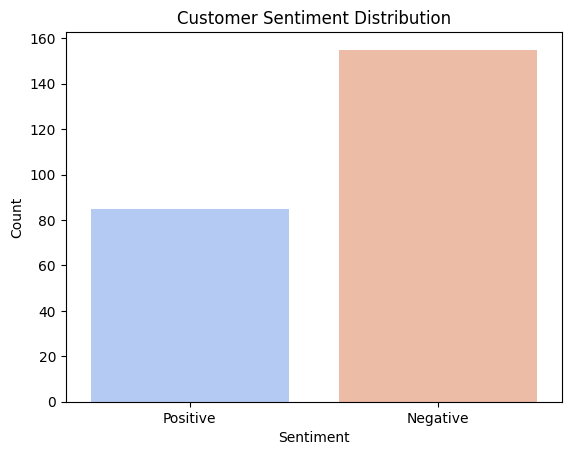

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=val_df, x='sentiment', palette='coolwarm')
plt.title("Customer Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [15]:
val_df.to_csv("predicted_feedback.csv", index=False)
print("Results saved as predicted_feedback.csv")


Results saved as predicted_feedback.csv


In [16]:
sentiment_counts = val_df['sentiment'].value_counts()
sentiment_percent = val_df['sentiment'].value_counts(normalize=True) * 100

print("Sentiment Distribution:")
print(sentiment_counts)
print("\n📊 Sentiment Percentage:")
print(sentiment_percent)


Sentiment Distribution:
sentiment
Negative    155
Positive     85
Name: count, dtype: int64

📊 Sentiment Percentage:
sentiment
Negative    64.583333
Positive    35.416667
Name: proportion, dtype: float64


Part 5 – Sentiment Analysis Results & Visualization


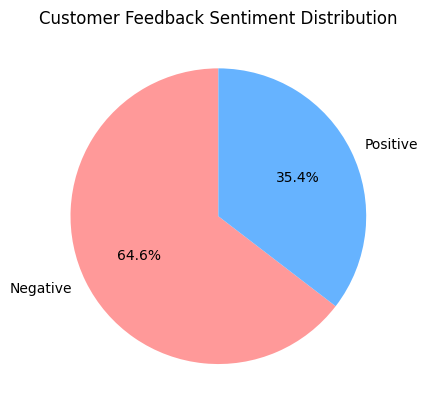

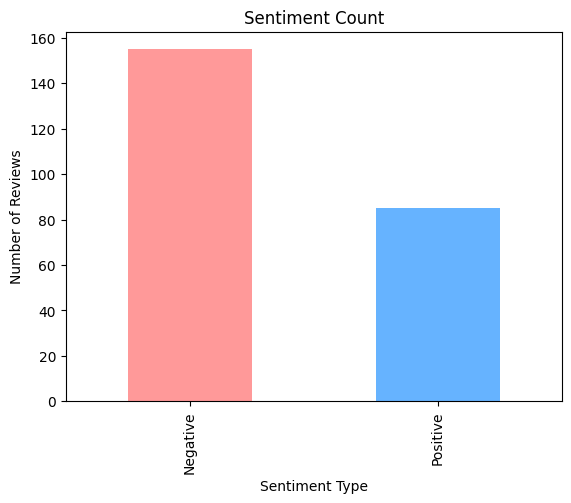

In [17]:
import matplotlib.pyplot as plt

sentiment_counts.plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
plt.title("Customer Feedback Sentiment Distribution")
plt.ylabel("")
plt.show()

sentiment_counts.plot(kind='bar', color=['#ff9999','#66b3ff'])
plt.title("Sentiment Count")
plt.xlabel("Sentiment Type")
plt.ylabel("Number of Reviews")
plt.show()


In [18]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [19]:
def generate_summary(text, max_length=60, min_length=20):
    input_text = "summarize: " + text
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

feedback = """
The product quality was excellent but the delivery took too long.
Customer service was helpful but could have been faster in resolving issues.
Overall, the experience was decent but there's room for improvement.
"""

print("Short Summary:\n", generate_summary(feedback, max_length=40, min_length=15))
print("\nDetailed Summary:\n", generate_summary(feedback, max_length=80, min_length=30))


Short Summary:
 the product quality was excellent but the delivery took too long. the experience was decent but there's room for improvement.

Detailed Summary:
 the product quality was excellent but the delivery took too long. customer service was helpful but could have been faster in resolving issues.


In [23]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=5)
X = vectorizer.fit_transform(df['clean_feedback'])

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Topic'] = kmeans.fit_predict(X)

terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(5):
    print(f"\nTopic {i}: ", end='')
    print(", ".join([terms[ind] for ind in order_centroids[i, :10]]))



Topic 0: adapter, power, apple, charger, charge, ibook, charging, powerbook, battery, computer

Topic 1: product, waist, size, wear, like, really, look, day, buy, small

Topic 2: game, album, cd, song, time, love, music, year, christmas, dvd

Topic 3: book, read, reading, character, like, story, good, novel, time, author

Topic 4: movie, sandler, funny, adam, film, watch, like, great, christmas, better


In [24]:
import datetime

if 'date' not in df.columns:
    np.random.seed(42)
    start = datetime.datetime(2025, 1, 1)
    df['date'] = [start + datetime.timedelta(days=np.random.randint(0,180)) for _ in range(len(df))]

df['sentiment_score'] = df['sentiment'].map({'positive':1, 'negative':0, 'neutral':0.5})


In [25]:
daily_sentiment = df.groupby('date')['sentiment_score'].mean().reset_index()
daily_sentiment.columns = ['ds', 'y']
daily_sentiment.head()


,ds,y
0,2025-01-01,NaN
1,2025-01-02,NaN
2,2025-01-03,NaN
3,2025-01-04,NaN
4,2025-01-05,NaN
